# Ebb & Flow

## Issue 2

Today I am going to take a look at a US Equity market statistical arbitrage strategy from academic literature. The paper I will be using for academic reference can be downloaded at this link: https://www.scribd.com/document/61438209/AvellanedaLeeStatArb20090616

Avellandea and Lee give a nice theoretical approach to statistical arbitrage and offer two different methods of implementation (PCA and ETF). As with most academic literature, however, much of the details and difficulties of actually implementing such a strategy are not discussed.

__The purpose of this issue will be to:__
    __1)__ Address implementation details with code
    __2)__ Consider trading challenges surrounding this strategy that are not discussed in the paper and
    __3)__ Think about how statistical techniques discussed in the paper can be used outside of the realm of traditional statistical arbitrage

### Implementing Principal Component Analysis

In the quantitative investing realm, and even in the fundamental realm, factor investing has gained popularity as of late. One of the most popular methods used to analyze and identify uncorrelated factors is principal component analysis. Before we jump into a PCA analysis, lets import some data and define our universe, which will be the SP500 over a 5 year time period from February 2013 to February 2018:

In [1]:
import pandas as p
import numpy as np
import sklearn.decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import usequity_functions as f
import importlib
importlib.reload(f)
from matplotlib import pyplot as plt

csv = 'all_stocks_5yr.csv'
index="date"
columns="Name"
values="close"

stocks_in = p.read_csv(csv)
stocks_in['date'] = p.to_datetime(stocks_in['date'])
stocks = f.reshape(stocks_in,index=index,columns=columns,values=values)
stocks_ret = f.get_ret(stocks)
stocks_ret = stocks_ret.iloc[1:len(stocks_ret)]
stocks = stocks.iloc[1:len(stocks)]

In [2]:
stocks_ret.iloc[0:5,0:7]

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT
date,,,,,,,
2013-02-11,-0.010648,-0.019661,-0.006464,0.010422,-0.011034,-0.002772,-0.004359
2013-02-12,0.000448,-0.013140,0.002679,-0.025067,-0.011994,0.004277,0.001168
2013-02-13,0.002913,0.027330,0.004707,-0.001903,-0.004235,-0.006814,0.004665
2013-02-14,-0.003799,-0.045703,-0.001646,-0.000899,0.036859,0.002787,0.006965
2013-02-15,-0.052266,0.036455,0.002029,-0.013780,0.027618,-0.003635,0.010951


This is a snapshot of our refined universe and corresponding daily returns. In order to run a PCA, I need to first estimate the correlation or covariance matrix. I will look at the correlation matrix as it is more intuitive if the reader does not have experience with PCA:

In [3]:
cor_mat = np.corrcoef(stocks_ret.T)
cor_mat_print = p.DataFrame(cor_mat)
cor_mat_print.index = cor_mat_print.columns = stocks_ret.columns
cor_mat_print.iloc[0:5,0:5]

Name,A,AAL,AAP,AAPL,ABBV
Name,,,,,
A,1.000000,0.292168,0.185823,0.275706,0.351972
AAL,0.292168,1.000000,0.191343,0.210004,0.225260
AAP,0.185823,0.191343,1.000000,0.127888,0.211054
AAPL,0.275706,0.210004,0.127888,1.000000,0.181927
ABBV,0.351972,0.225260,0.211054,0.181927,1.000000


Here we see a snapshot of the correlation matrix for reference. It should be noted that one of the most explored topics in quantitative finance is proper estimation of the correlation (or covariance) matrix through shrinkage or regularization. We will skip this issue for now, but if we are to ever get a stat arb strategy up and running, this is crucial to consider. 

Now lets calculate eigenvalues and eigenvectors of our data set by running a PCA. Eigenvectors (returned at unit length) can be thought of as __standardized__ portfolio weights for uncorrelated factors and the eigenvalue corresponding to each eigenvector can be considered the amount of variance that each factor explains relating to the original dataset.

In [4]:
eig_vals,eig_vecs = np.linalg.eig(cor_mat)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

Since eigenvalues explain the variance of each uncorrelated factor in our dataset, lets plot each eigenvalue and their cumulative sum for the first 20 factors to get a feel for the structure of our universe:

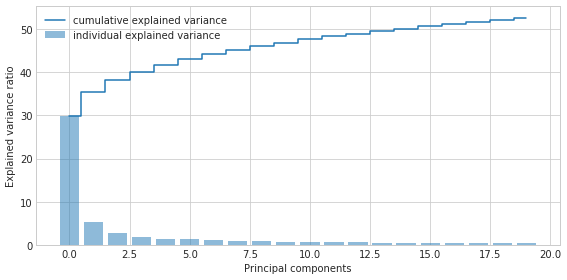

In [5]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
var_exp = var_exp[0:20] ## took top 20
cum_var_exp = np.cumsum(var_exp)
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 4))

    plt.bar(range(20), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(20), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

As we see, and perhaps expect, our universe is dominated by the first principal component, which is widely considered the "market" factor. One of the most overlooked realities of the stock market, however, is the dynamic nature of the factor structure. Running a PCA on the entire data set shows (above) that the market factor represents about 30 percent of the variance of the entire set. If we run a PCA on a rolling subset of our 5-year time period, we see significant variability in our factor structure across time. 

An extension of my research from issue 1 notes that when overall market volatility is high (represented by the VIX), the market factor explains more of the variance in our data and when the VIX is comparably low, it explains less. This may seem obvious but it is important to consider. Another way to think about this idea is that __systematic__ components are a stronger driver of return in high VIX environments and __idiosyncratic__ components are a stronger driver of return in low VIX environments. There is more likely to be mispricings in individual stocks in high VIX environments.

I also want to mention that while it is widely accepted that the first principal component is almost always the market factor, it is unclear what the 2nd, 3rd, 4th etc components are at any given time. I think it is reasonable to say that these remaining components are time varying. 

To illustrate the changing factor structure, lets run a PCA on the last 30 days noting from qualitative observation that volatility has been much higher than the average of our dataset (I used an asyptotic approach as a 30 x 470 matrix is not invertible. This is an a topic for another time):

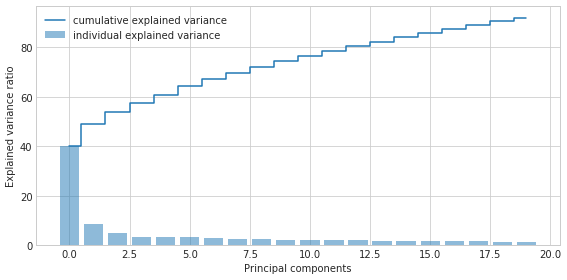

In [7]:
stocks_ret_subset = stocks_ret.iloc[-30:]
cor_mat_sub = np.corrcoef(stocks_ret_subset.T)
eig_vals_sub,eig_vecs_sub = np.linalg.eig(cor_mat_sub)
eig_pairs_sub = [(np.abs(eig_vals_sub[i]), eig_vecs_sub[:,i]) for i in range(len(eig_vals_sub))]
eig_pairs_sub.sort(key=lambda x: x[0], reverse=True)

tot_sub = sum(eig_vals_sub)
var_exp_sub = [(i / tot_sub)*100 for i in sorted(eig_vals_sub, reverse=True)]
var_exp_sub = var_exp_sub[0:20] ## took top 20
cum_var_exp_sub = np.cumsum(var_exp_sub)
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(8, 4))

    plt.bar(range(20), var_exp_sub, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(20), cum_var_exp_sub, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
import warnings; warnings.simplefilter('ignore')

Here we can see the significant difference in factor structure. The market factor explains 40 percent of variance now and the first 2 principal components  explain about 50 percent. Compare this to the graph from our previous example where we needed roughly 12 factors to explain 50 percent of variance.

#### PCA in Statistical Arbitrage

Now lets talk a little bit about how PCA is used in a conventional statistical arbitrage strategy. As stated by Avellaneda and Lee (2009), a conventional statistical arbitrage strategy is just a collection of pairs trades. The goal is to model the relative value of one stock versus a basket of stocks and trade market neutral positions (long the stock and short the factor or visa versa) when the relative value of the two components diverges far from its theoretical value. 

More specifically, a stat arb strategy typically "purges" individual stocks of its systematic component by regressing individual stock returns (or manually contructed portfolios) on systematic components (such as factors calculated via PCA) and then models its residuals as a mean reverting process. __The residuals of the regression correspond to the variability in stock returns NOT explained by our selected principal components__.

Now lets consider actually trading this strategy, which is not discussed in Avellaneda and Lee: 

The alpha of these time series regressions is considered the abnormal return. From rearranging a simple 2 factor model equation as an example (this can be applied to any number of factors) we can see that return not explained by our factors is directly attributable to alpha and epsilon, and can intuit how conditionally modelling epsilon will help us find alpha __relative to our betas__.

It is important to also note that in order to trade this in a market neutral fashion, as nearly all statistical arbitrage strategies do, we will need to scale our portfolio weights so that beta is equal to 1. I have provided an analytical solution for solving for these weights with a 2 factor model. In industry, proxies are often used to represent factors and the following portfolio weight calculations are not needed since eigenvectors, a collection of N assets, is replaced with 1 asset. That said, if we ever want to calculate weights for a smaller universe, this analytical solution will be very useful: 

$Scale \, portfolio \, weights \, so \, beta \, equals \, 1:$

$$ Y = \alpha + \beta_{1} Return_{F1} + \beta_{2} Return_{F2} + \epsilon$$

$$ Y = \alpha + 1*weights + \epsilon$$

$$ \alpha + \epsilon = Y - weights $$

$$ where \, weights \, is \, a \, vector \, combining \, factor \, exposure \, scaled \, so \,\, \beta =1 \quad {**} see \, construction  $$

 ${Uncondiationally:}$
           
$$\sum_{i=0}^N \epsilon_{i} = 0$$

 ${Conditionally:}$ 
                    
$$\sum_{i=0}^n \epsilon_{i} \not = 0  \quad where \, n \, is \, a \, subset\, of\,N $$

$${**}Construction:$$
            
$$ Y = \alpha + \beta_{1} Return_{F1} + \beta_{2} Return_{F2} + \epsilon$$

$$ \quad where \quad Return_{F1} = \, Eigenvector_1*R_{t} \,\,\, and \,\,\, Return_{F2} = \, Eigenvector_2*R_{t} $$

$$ Vec_{12} = \beta_{1} * {Eigenvector_1} + \beta_{2} * {Eigenvector_2}$$ 

$$\quad where \quad Vec_{12} \, is \, portfolio \, weights\, with \, combined \, exposure \, to \, Factor_1 \, and \, Factor_2 $$

$$ Y = \alpha + \beta_{3} * Vec_{12} + \epsilon$$

$$ w = \beta_{1} * \beta_{3} * {Eigenvector_1}  +  \beta_{2} * \beta_{3} * {Eigenvector_2} $$

$$ \quad where \quad w = scaled \, weights $$

$$ Y = \alpha + \beta_{4}*w + \epsilon $$

$$ \quad where \quad \beta_{4} = 1 $$

In this particular situation, our weights are scaled for market neutrality, but they can be scaled in practice to have any desired beta exposure. As mentioned before, statistical arbitrage strategies conditionally predict the residuals of the regression above and look to trade it back to its theoretical value with expectation of quick mean reversion. This is formalized by creating a test statitic that measures distance from the mean, similar to a z-score for a normal distribution.

__I am more interested, however, in looking at alpha that is persistent in the market.__ Instead of using PCA or similar techniques to trade mean reversion back to a mathematical equilibrium, I will design strategies that offer alpha above a benchmark but likely co-move with this benchmark. Technically, this means I am okay with beta exposure and will often not need to trade the benchmark (a common implementation difficulty of market neutrality).

In future issues, I will search for this alpha by creating portfolios based on accounting , financial and trading specific variables.  A simple example is to create a portfolio based on categorical variables. I will look at nine variables in particular, and assign a 1 if the signal is a positive development and a 0 if it is a negative development. I will then aggregate these scores for all stocks in my universe, sort into deciles and regress top performing deciles minus lesser performing deciles on the benchmark return. The accounting variables I will look at to create an F-score with are:

* 1) Return on Assets
* 2) CFO: earnings + depreciation - (CA-CL)
* 3) Change in ROA
* 4) Accruals
* 5) Change in leverage: change in (LTD-TA)
* 6) Change in liquidity: change in (CA-CL)
* 7) EQ Offer: did company issue common stocks?
* 8) Change in gross margin: change in (gross profit / net sales)
* 9) Change in asset turnover ratio: change in (revenue / average total assets)

Since the goal is to outperform a benchmark, we need to define that benchmark. I will conclude this issue with some descriptive statistics regarding association of individual stocks in our universe with factors. Remember, that in order to trade these factors we need to use the portfolio weights calculated via eigenvectors. In our universe, each eigenvector has 470 components which means trading every one of those stocks to get exposure to the latent factor. In practice, this is rather unrealistic. We can solve this over trading issue in two ways: __1)__ we can significantly reduce our universe or __2)__ we can use a proxy for factor returns. Using a proxy, such as an ETF to represent our systematic variable is commonplace in practice. It is difficult to identify good proxies, however, without running a PCA.


The following formula will give us standardized factor returns which we can use to identify the strength of association of each stock with each factor:

$$ F_{jt} = \sum_{i=1}^n (\frac{1}{\sqrt{\lambda_{j}}} * \frac{Vj_{i}}{\sigma_{i}})*R_{it}$$

Lets do this in code on a two year sample:


In [12]:
i=0
stocks = stocks.iloc[i:i+504]
stocks_ret = stocks_ret.iloc[i:i+504]
factor_returns = []
num_comps = 3
sigma_bar = stocks_ret.apply(np.std,axis=0)
stocks_ret_std = StandardScaler().fit_transform(stocks_ret)
stocks_ret_std = p.DataFrame(stocks_ret_std)
stocks_ret_std.index = stocks_ret.index
for i in range(num_comps):
    V = eig_pairs[i][1]  #standardized eigenvector, numpy standardizes automatically
    eig_val = eig_pairs[i][0]
    portfolio_weights = (1/np.sqrt(eig_val)) * (V / sigma_bar) ## run standardized returns against this
    portfolio_weights1 = V                    ## non standardized rets, if i standardize after will it be the same?
    ## last row of stocks _ret, trailing 252 day window, local variable
    F = np.matmul(stocks_ret,portfolio_weights) 
    factor_returns.append(F)

factor_returns = p.DataFrame(factor_returns).T
factor_returns.index = stocks_ret.index

intercept = p.Series(np.ones(len(factor_returns)),index=factor_returns.index)
X = p.concat([intercept,factor_returns],axis =1 )
X = X[-60:]
# this function only needs to take in y because we are not iterating X
def matrix_regression(y):
    b = np.matmul(np.matmul(np.linalg.inv(np.matmul(X.T,X)),X.T),y)
    e = y - np.matmul(X,b)
    return list(b) , list(e)

betas = []
residuals = []

for j in range(len(stocks_ret.columns)):
    b = matrix_regression(stocks_ret_std.iloc[-60:,j])[0]
    e = matrix_regression(stocks_ret_std.iloc[-60:,j])[1]
    betas.append(b)
    residuals.append(e)


out_betas = p.DataFrame(betas)
out_resid = p.DataFrame(residuals)
out_betas.index =  stocks_ret.columns
out_betas.columns = ['Intercept','PC1','PC2','PC3']
out_resid.index = stocks_ret.columns  

out_betas.iloc[100:110,1:5]*-1

,PC1,PC2,PC3
Name,,,
CMI,0.557737,-0.032992,0.100275
CMS,0.464087,-0.794050,0.209554
CNC,0.325731,-0.045411,-0.028483
CNP,0.690558,-0.448665,0.292630
COF,0.615758,0.113391,-0.104251
COG,0.252130,0.092892,0.250614
COL,0.482115,-0.042353,-0.060417
COO,0.473383,-0.171672,-0.001763
COP,0.800334,0.251649,0.639363


In [13]:
out_resid.iloc[100:110,1:7]*-1

,1,2,3,4,5,6
Name,,,,,,
CMI,-0.349058,0.145802,0.221249,0.641513,-0.231436,-1.699294
CMS,-0.077971,-0.229609,0.160163,0.170610,0.409655,0.045226
CNC,0.411780,-0.565699,0.120376,0.083662,0.022133,0.599447
CNP,0.182206,-0.617575,-0.457541,0.474514,0.249605,0.776686
COF,-0.398990,0.447185,0.198728,0.437175,-0.435021,0.125504
COG,-1.145442,-0.077324,0.333445,-1.205746,-0.674571,0.772493
COL,0.595124,0.698568,0.135737,-0.611149,0.038198,0.226661
COO,-0.304748,-1.455226,-1.744702,0.799868,0.223380,0.486449
COP,-0.091645,-0.261159,-0.042297,-0.237004,0.065249,0.901505


Here is an excerpt from our beta estimates (table1) and the corresponding residuals (table2). These betas are standardized and thus can be interpreted as correlations to each PC. The residuals are also standardized and can be considered the distance in standard deviations from the unconditional mean (zero). Remember, each PC is uncorrelated with one another. I will close the issue with this. Please think about how we could use the information in these tables to design a strategy relative to a benchmark or systematic component.